# Monte Carlo option pricing (without and with pyspark)

##  Generating and plotting white noise, Wiener process and asset price process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyspark

Number of simulations (samples), maturity time, number of time-steps in simulation, size of timestep:

In [2]:
nr_samples=10; T=10; nr_steps=100; dt=T/nr_steps

Functions for generating samples of Wiener process or asset price process, given a normally distributed sample of white noise:

In [3]:
def wiener_sample(dt, normal_sample):
    W=np.zeros(nr_steps+1)
    sqdt=np.sqrt(dt)
    for k in range(1,nr_steps+1):
        W[k]=W[k-1] + normal_sample[k-1]*sqdt
    return W 

In [4]:
def asset_sample(mu, sigma, S0, dt, normal_sample):
    S=np.zeros(nr_steps+1)
    sqdt=np.sqrt(dt)
    S[0]=S0
    for k in range(1,nr_steps+1):
        S[k]=S[k-1] + mu*S[k-1]*dt + sigma*S[k-1]*normal_sample[k-1]*sqdt
    return S 

Samples of (normally distributed) white noise:

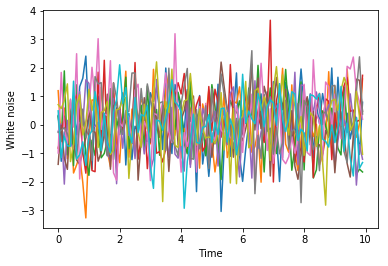

In [5]:
normal_samples=np.random.normal(0,1,[nr_samples,nr_steps])
plt.plot(np.arange(0,T,dt),np.transpose(normal_samples))
plt.xlabel('Time')
plt.ylabel('White noise')
plt.show()

Generating samples of Wiener process and asset price process using generated white noise:

In [6]:
asset_samples=np.zeros([nr_samples,nr_steps+1])
wiener_samples=np.zeros([nr_samples,nr_steps+1])
for k in range(0,nr_samples):
    wiener_samples[k,:]=wiener_sample(dt, normal_samples[k,:])
    asset_samples[k,:]=asset_sample(0.1, 0.5, 1, dt, normal_samples[k,:])

Samples of Wiener process:

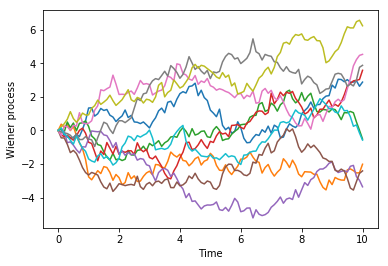

In [7]:
plt.plot(np.arange(0,T+dt,dt),np.transpose(wiener_samples))
plt.xlabel('Time')
plt.ylabel('Wiener process')
plt.show()

Samples of asset price process:

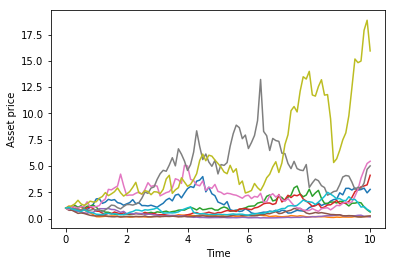

In [8]:
plt.plot(np.arange(0,T+dt,dt),np.transpose(asset_samples))
plt.xlabel('Time')
plt.ylabel('Asset price')
plt.show()

## Pricing european and asian call (without pyspark)

Estimation of European call price:

In [9]:
nr_samples=10000; T=10; nr_steps=100; dt=T/nr_steps
normal_samples=np.random.normal(0,1,[nr_samples,nr_steps])
asset_samples=np.zeros([nr_samples,nr_steps+1])
for k in range(0,nr_samples):
    asset_samples[k,:]=asset_sample(0.1, 0.5, 1, dt, normal_samples[k,:])

K=6
final_asset_price=asset_samples[:,nr_steps]
EUcall_samples=np.maximum(final_asset_price-K,0)
EUcall=np.mean(EUcall_samples)
EUcall

1.0406201989384238

Estimation of Asian call price:

In [10]:
nr_samples=10000; T=10; nr_steps=100; dt=T/nr_steps
normal_samples=np.random.normal(0,1,[nr_samples,nr_steps])
asset_samples=np.zeros([nr_samples,nr_steps+1])
for k in range(0,nr_samples):
    asset_samples[k,:]=asset_sample(0.1, 0.5, 1, dt, normal_samples[k,:])

K=6
mean_asset_price=np.mean(asset_samples, axis=1)
Asiacall_samples=np.maximum(mean_asset_price-K,0)
Asiacall=np.mean(Asiacall_samples)
Asiacall

0.16459293881144285

## Generating and plotting asset price process with pyspark

Creating SparkContext object:

In [11]:
try: sc=pyspark.SparkContext()
except ValueError: print("Sparkcontext was allready generated!")
else: 0

Playing arround with rdds :-) :

In [12]:
rdd0=sc.parallelize(np.array([[1,2],[2,3]]))
rdd1=rdd0.map(lambda x: x[1])
print(rdd0)
print(rdd1)
print(rdd0.collect())
print(rdd1.collect())
rdd0

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:480
PythonRDD[1] at RDD at PythonRDD.scala:48
[array([1, 2]), array([2, 3])]
[2, 3]


ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:480

Function for generating normal white noise:

In [13]:
def normal_sample(nr_steps):
    np.random.seed() #without this random number generating will start in each clusterwith the same seed  
    #and we will not get enough different random paths
    return np.random.normal(0,1,nr_steps)

Creating basic rdd that will only determine how many asset price process samples we will generate:

In [14]:
nr_samples=10; T=10; nr_steps=100; dt=T/nr_steps
rdd0=sc.parallelize(range(0,nr_samples))

Transforming the rdd to create a rdd of asset price process samples:

In [15]:
rdd_asset_samples0=rdd0.map(lambda x: normal_sample(nr_steps)).map(lambda x: asset_sample(0.1, 0.5, 1, dt, x))

Plotting asset price process samples, and printing final asset values (not corresponding to the figure, see comment in second piece of code):

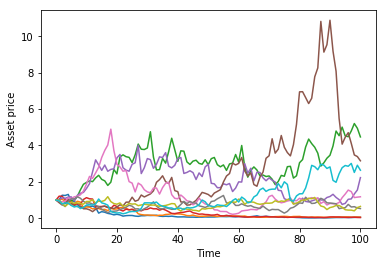

In [16]:
asset_samples0=np.array(rdd_asset_samples0.collect())

plt.plot(np.transpose(asset_samples0))
plt.xlabel('Time')
plt.ylabel('Asset price')
plt.show()

In [17]:
rdd_asset_samples0.map(lambda x: x[nr_steps]).collect() #these are not final prices from the previous figure, 
# as each action (e.g. collect, take) causes new evaluating of all previous transformations (e.g. map)

[6.4548502618531662,
 0.67651294091545022,
 4.0573142678551575,
 0.095859746424810918,
 5.5092927005808052,
 0.20915787817511705,
 0.63379923786694903,
 0.042733775008332656,
 1.312980707393018,
 3.3271049638468848]

## Pricing european and asian call with pyspark

Estimation of European call price -pyspark version:

In [18]:
K=6
nr_samples=10000; T=10; nr_steps=100; dt=T/nr_steps
rdd0=sc.parallelize(range(0,nr_samples))
rdd_asset_samples1=rdd0.map(lambda x: normal_sample(nr_steps)).map(lambda x: asset_sample(0.1, 0.5, 1, dt, x))
EUcall1=1/nr_samples*rdd_asset_samples1.map(lambda x: np.maximum(x[nr_steps]-K,0)).reduce(lambda x,y: x+y)
EUcall1

1.0145228323635904

Estimation of Asian call price -pyspark version:

In [19]:
K=6
nr_samples=10000; T=10; nr_steps=100; dt=T/nr_steps
rdd0=sc.parallelize(range(0,nr_samples))
rdd_asset_samples1=rdd0.map(lambda x: normal_sample(nr_steps)).map(lambda x: asset_sample(0.1, 0.5, 1, dt, x))
Asiacall1=1/nr_samples*rdd_asset_samples1.map(lambda x: np.maximum(np.mean(x)-K,0)).reduce(lambda x,y:x+y)
Asiacall1

0.17844352945389874